In [4]:
import enflow as em

ModuleNotFoundError: No module named 'enflow'

In [ ]:
!pip install -q pyomo==6.6.2
!apt-get install -y -qq coinor-cbc
solver = {'name':"cbc",'path': "/usr/bin/cbc"}

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/GSE/'

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FixedLocator, MultipleLocator
import os
import sys

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
@dataclass
class State: 
    R_t: float
    p_t: float

In [6]:
sys.path.append(path)

In [7]:
from gse.gse import create_model, instantiate_model, solve_model, get_results
from gse.gse_input import create_input

In [8]:
# Import data
df_load = pd.read_csv(f'{path}/data/load.csv', index_col = 0, parse_dates = True)
df_pv = pd.read_csv(f'{path}/data/pv.csv', index_col = 0, parse_dates = True)
df_grid = pd.read_csv(f'{path}/data/grid.csv', index_col = 0, parse_dates = True)
df_battery = pd.read_csv(f'{path}/data/battery.csv', index_col = 0)

In [11]:
df_grid

,market rate,feedin tariff,community fee,grid fee
Datetime,,,,
2014-10-01 00:00:00,22.0,21.9,3.0,4.0
2014-10-01 00:15:00,22.0,21.9,3.0,4.0
2014-10-01 00:30:00,22.0,21.9,3.0,4.0
2014-10-01 00:45:00,22.0,21.9,3.0,4.0
2014-10-01 01:00:00,22.0,21.9,3.0,4.0
...,...,...,...,...
2014-10-30 22:45:00,22.0,21.9,3.0,4.0
2014-10-30 23:00:00,22.0,21.9,3.0,4.0
2014-10-30 23:15:00,22.0,21.9,3.0,4.0


In [12]:
houses_with_demand = list(df_load.columns)
houses_with_generation = list(df_pv.columns)
houses_with_battery = list(df_battery.columns)
houses = list(set(houses_with_demand+houses_with_generation+houses_with_battery))

In [13]:
#%% Base scenario - Individual operation

battery_soc_base = pd.DataFrame(index = df_load.index, columns=houses)
battery_charge_base = pd.DataFrame(index = df_load.index, columns=houses)
power_buy_base = pd.DataFrame(index = df_load.index, columns=houses)
power_sell_base = pd.DataFrame(index = df_load.index, columns=houses)
cost_energy_base_ = pd.DataFrame(index = df_load.index, columns=houses)
cost_grid_base_ = pd.DataFrame(index = df_load.index, columns=houses)

for h in houses:

    load_data = df_load[[h]] if h in df_load.columns else pd.DataFrame(index = df_load.index)
    generation_data = df_pv[[h]] if h in df_pv.columns else pd.DataFrame(index = df_load.index)
    battery_data = df_battery[[h]] if h in df_battery.columns else pd.DataFrame(index = df_load.index)
    grid_data = df_grid

    # Create data input for model
    model_data = create_input(load_data,generation_data,grid_data,battery_data)
    # Create model
    mdl = create_model()
    # Instantiate model with data
    m = instantiate_model(mdl, model_data)
    # Solve model
    s = solve_model(m, solver)
    # Get solution as python dictionary
    sd = get_results(s)

    battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
    battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
    power_buy_base.loc[:,h] = sd['power_buy'][h] if h in sd['power_buy'].keys() else 0.0
    power_sell_base.loc[:,h] = sd['power_sell'][h] if h in sd['power_sell'].keys() else 0.0
    cost_energy_base_.loc[:,h] = sd['cost_energy']
    cost_grid_base_.loc[:,h] = sd['cost_grid']

cost_energy_base = cost_energy_base_.sum(axis=1).to_frame(name = 'Energy Cost')
cost_grid_base = cost_grid_base_.sum(axis=1).to_frame(name = 'Grid Cost')

cost_energy_base_total = cost_energy_base.sum()[0]
cost_grid_base_total = cost_grid_base.sum()[0]
cost_base_total = cost_energy_base_total + cost_grid_base_total

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpjcxi21yu.pyomo.lp -stat=1 -solve -solu /tmp/tmpjcxi21yu.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23689 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp7jigtu_4.pyomo.lp -stat=1 -solve -solu /tmp/tmp7jigtu_4.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8636 (-23044) rows, 20151 (-5769) columns and 34542 (-37457) elements
Statistics for presolved model


Problem has 8636 rows, 20151 columns (8638 with objective) and 34542 elements
There are 5760 singletons with objective 
Column breakdown:
11512 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5759 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2876 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8636 (-23044)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp67biyte4.pyomo.lp -stat=1 -solve -solu /tmp/tmp67biyte4.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8640 (-23040) rows, 20159 (-5761) columns and 34558 (-37441) elements
Statistics for presolved model


Problem has 8640 rows, 20159 columns (8640 with objective) and 34558 elements
There are 5760 singletons with objective 
Column breakdown:
11520 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5761 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2878 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8640 (-23040)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpcru4x358.pyomo.lp -stat=1 -solve -solu /tmp/tmpcru4x358.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23004 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpjkek5nxb.pyomo.lp -stat=1 -solve -solu /tmp/tmpjkek5nxb.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8640 (-23040) rows, 20159 (-5761) columns and 34558 (-37441) elements
Statistics for presolved model


Problem has 8640 rows, 20159 columns (8640 with objective) and 34558 elements
There are 5760 singletons with objective 
Column breakdown:
11520 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5759 of type E 0.0, 0 of type E 1.0, 1 of type E -1.0, 
2879 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8640 (-23040)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpuph7_lmt.pyomo.lp -stat=1 -solve -solu /tmp/tmpuph7_lmt.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23764 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpqfwukxoz.pyomo.lp -stat=1 -solve -solu /tmp/tmpqfwukxoz.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23653 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpex7n1psg.pyomo.lp -stat=1 -solve -solu /tmp/tmpex7n1psg.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23440 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpy9c1alqn.pyomo.lp -stat=1 -solve -solu /tmp/tmpy9c1alqn.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22753 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp6bb_10xb.pyomo.lp -stat=1 -solve -solu /tmp/tmp6bb_10xb.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22010 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpr4mtfmqy.pyomo.lp -stat=1 -solve -solu /tmp/tmpr4mtfmqy.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8638 (-23042) rows, 20155 (-5765) columns and 34550 (-37449) elements
Statistics for presolved model


Problem has 8638 rows, 20155 columns (8639 with objective) and 34550 elements
There are 5760 singletons with objective 
Column breakdown:
11516 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5758 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2879 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8638 (-23042)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp__6niqoe.pyomo.lp -stat=1 -solve -solu /tmp/tmp__6niqoe.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23698 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpb8l_4ic2.pyomo.lp -stat=1 -solve -solu /tmp/tmpb8l_4ic2.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8640 (-23040) rows, 20159 (-5761) columns and 34558 (-37441) elements
Statistics for presolved model


Problem has 8640 rows, 20159 columns (8640 with objective) and 34558 elements
There are 5760 singletons with objective 
Column breakdown:
11520 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5760 of type E 0.0, 0 of type E 1.0, 1 of type E -1.0, 
2878 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8640 (-23040)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpwribelq9.pyomo.lp -stat=1 -solve -solu /tmp/tmpwribelq9.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23077 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp1tmzyqzh.pyomo.lp -stat=1 -solve -solu /tmp/tmp1tmzyqzh.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8632 (-23048) rows, 20143 (-5777) columns and 34526 (-37473) elements
Statistics for presolved model


Problem has 8632 rows, 20143 columns (8636 with objective) and 34526 elements
There are 5760 singletons with objective 
Column breakdown:
11504 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5756 of type E 0.0, 1 of type E 1.0, 0 of type E -1.0, 
2874 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8632 (-23048)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp4w1er9v9.pyomo.lp -stat=1 -solve -solu /tmp/tmp4w1er9v9.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23637 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpux916stb.pyomo.lp -stat=1 -solve -solu /tmp/tmpux916stb.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22040 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp8ov3ra6q.pyomo.lp -stat=1 -solve -solu /tmp/tmp8ov3ra6q.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8640 (-23040) rows, 20159 (-5761) columns and 34558 (-37441) elements
Statistics for presolved model


Problem has 8640 rows, 20159 columns (8640 with objective) and 34558 elements
There are 5760 singletons with objective 
Column breakdown:
11520 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5759 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2880 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8640 (-23040)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmphamr17ex.pyomo.lp -stat=1 -solve -solu /tmp/tmphamr17ex.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8638 (-23042) rows, 20155 (-5765) columns and 34550 (-37449) elements
Statistics for presolved model


Problem has 8638 rows, 20155 columns (8639 with objective) and 34550 elements
There are 5760 singletons with objective 
Column breakdown:
11516 of type 0.0->inf, 8639 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
5760 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
2877 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Presolve 8638 (-23042)

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp7d0ll00t.pyomo.lp -stat=1 -solve -solu /tmp/tmp7d0ll00t.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37440) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22484 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-11520) rows, 0 (-17280) columns and 0 (-37

<ipython-input-13-b189a6af81e5>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-13-b189a6af81e5>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

In [15]:
#%% Community scenario - Operation as energy community

battery_soc_community = pd.DataFrame(index = df_load.index, columns=houses)
battery_charge_community = pd.DataFrame(index = df_load.index, columns=houses)
power_buy_community = pd.DataFrame(index = df_load.index, columns=houses)
power_sell_community = pd.DataFrame(index = df_load.index, columns=houses)
cost_energy_community = pd.DataFrame(index = df_load.index, columns=['Energy Cost'])
cost_grid_community = pd.DataFrame(index = df_load.index, columns=['Grid Cost'])

load_data = df_load
generation_data = df_pv
battery_data = df_battery
grid_data = df_grid

# Create data input for model
model_data = create_input(load_data,generation_data,grid_data,battery_data)
# Create model
mdl = create_model()
# Instantiate model with data
m = instantiate_model(mdl, model_data)
# Solve model
s = solve_model(m, solver)
# Get solution as python dictionary
sd = get_results(s)


for h in houses:
    battery_soc_community.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
    battery_charge_community.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
    power_buy_community.loc[:,h] = sd['power_buy'][h] if h in sd['power_buy'].keys() else 0.0
    power_sell_community.loc[:,h] = sd['power_sell'][h] if h in sd['power_sell'].keys() else 0.0

cost_energy_community['Energy Cost'] = sd['cost_energy']
cost_grid_community['Grid Cost'] = sd['cost_grid']

cost_energy_community_total = cost_energy_community.sum()[0]
cost_grid_community_total = cost_grid_community.sum()[0]
cost_community_total = cost_energy_community_total + cost_grid_community_total

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp_q1ncyz8.pyomo.lp -stat=1 -solve -solu /tmp/tmp_q1ncyz8.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 48952 (-178568) rows, 120936 (-74904) columns and 236112 (-351400) elements
Statistics for presolved model


Problem has 48952 rows, 120936 columns (28804 with objective) and 236112 elements
There are 5760 singletons with objective 
Column breakdown:
51824 of type 0.0->inf, 69112 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
23040 of type E 0.0, 1 of type E 1.0, 2 of type E -1.0, 
25901 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 8 of type Range other, 
0 of type Free 
Presolve 

<ipython-input-15-871e02fdafd0>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_soc_community.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
<ipython-input-15-871e02fdafd0>:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  battery_charge_community.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
<ipython-input-15-871e02fdafd0>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. 

<Figure size 1000x1000 with 0 Axes>

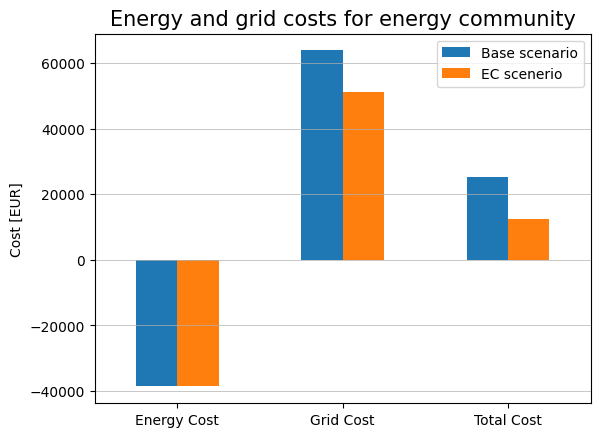

In [16]:
#%% Plots
costs = [[cost_energy_base_total,cost_grid_base_total,cost_base_total],
     [cost_energy_community_total,cost_grid_community_total,cost_community_total]]
costs = pd.DataFrame(costs, columns=['Energy Cost','Grid Cost', 'Total Cost'])


fig = plt.figure(figsize=(10, 10))
ax = costs.T.plot(kind='bar', rot=0, legend=True)
ax.set_title('Energy and grid costs for energy community', fontsize=15)
ax.set_ylabel('Cost [EUR]', fontsize=10)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, labelleft=True)
ax.legend(['Base scenario', 'EC scenerio'], loc=0, fontsize=10)
ax.grid(axis = 'y', linestyle='-', linewidth=0.5)

<Figure size 2000x1000 with 0 Axes>

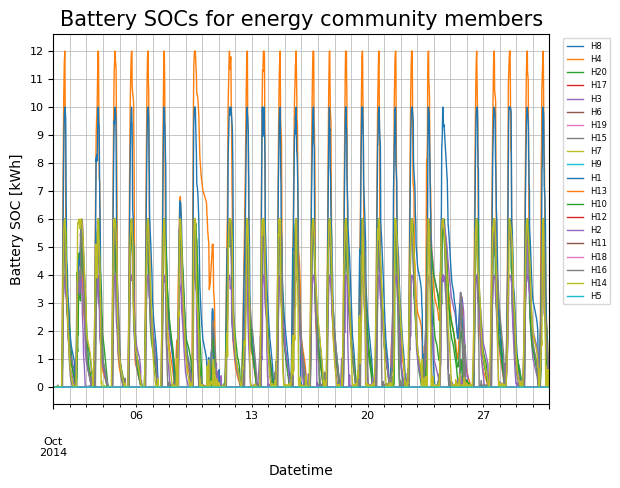

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = battery_soc_community.plot(kind='line', rot=0, legend=False, linewidth=1.0)
ax.set_title('Battery SOCs for energy community members', fontsize=15)
ax.set_ylabel('Battery SOC [kWh]', fontsize=10)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
               labelbottom=True, labelleft=True)
ax.grid(which = 'both', linestyle='-', linewidth=0.5)
ax.legend(fontsize=6,bbox_to_anchor=(1.02, 1.0))